# 03 Spatial Validation & Tier Assignment

**Question**: How do we validate geocoded coordinates and assign quality tiers?

**Purpose**: Validate Google Maps geocoding results against tambon polygons, generate fallback coordinates for failed units, and assign quality tiers (A+/D).

**Tech Summary**:
- **Input**: 
  - `../intermediate/google_geocoding_raw.parquet` (Google Maps geocoding results)
  - `../shapefiles/tambon_DOL_utf8.gpkg` (Department of Lands tambon boundaries)
  - `../shapefiles/BMA_ADMIN_SUB_DISTRICT.gpkg` (Bangkok sub-districts)
  - `../shapefiles/เขตการเลือกตั้ง 66/2566_TH_ECT_attributes.shp` (ECT electoral districts)
- **Process**:
  - Load tambon/district shapefiles
  - Filter Google results: keep only points within correct tambon polygon
  - Generate random points within tambon for unmatched units
  - Assign quality tiers (A+ = validated, D = synthetic)
- **Output**: `../outputs/ect66_geocoded_validated.parquet` ✅ **FINAL DATASET**
- **Dependencies**: geopandas, shapely, pydantic

**Status**: ✅ Ready to run

---

In [1]:
import pandas as pd
import geopandas as gpd
from pydantic import BaseModel
import shapely
from shapely.geometry import Point
import random

# transform google location data

In [2]:
class GMapEntry(BaseModel):
    lat: float
    lng: float
    place_id: str
    formatted_address: str

    @classmethod
    def from_geocode_result(cls, result):
        return cls(
            lat=result["geometry"]["location"]["lat"],
            lng=result["geometry"]["location"]["lng"],
            place_id=result["place_id"],
            formatted_address=result["formatted_address"],
        )

    @property
    def point(self):
        return Point(self.lng, self.lat)

In [ ]:
gdf = pd.read_parquet("../intermediate/google_geocoding_raw.parquet")
gdf.head()

In [4]:
def change_to_GMapEntry(x):
    return [GMapEntry.from_geocode_result(i) for i in x]


gdf["GMapObjs"] = gdf["GMap"].apply(change_to_GMapEntry)
gdf["GMapLen"] = gdf["GMapObjs"].apply(len)

In [5]:
gdf["GMapLen"].value_counts()

GMapLen
1    81845
2     9496
0     2810
3     1012
4       81
5        4
6        1
Name: count, dtype: int64

# Tambon Variation

In [ ]:
# Load tambon polygons from Department of Lands
tb = gpd.read_file(r"../shapefiles/tambon_DOL_utf8.gpkg")

# convert to lat, lng epsg:4326
tb = tb.to_crs(epsg=4326)

In [7]:
tb.head()

,OBJECTID,P_CODE,A_CODE,T_CODE,P_NAME_T,P_NAME_E,A_NAME_T,A_NAME_E,T_NAME_T,T_NAME_E,geometry
0,109,30,10,12,นครราชสีมา,NAKHON RATCHASIMA,โนนสูง,NON SUNG,ด่านคล้า,DAN KHLA,"POLYGON ((102.24798 15.17245, 102.24760 15.172..."
1,110,43,05,08,หนองคาย,NONG KHAI,โพนพิสัย,PHON PHISAI,นาหนัง,NA NANG,"POLYGON ((103.17289 17.93236, 103.17321 17.931..."
2,111,72,01,03,สุพรรณบุรี,SUPHAN BURI,เมืองสุพรรณบุรี,MUEANG SUPHAN BURI,ทับตีเหล็ก,THAP TI LEK,"POLYGON ((100.12036 14.45275, 100.12083 14.451..."
3,112,36,07,02,ชัยภูมิ,CHAIYAPHUM,บำเหน็จณรงค์,BAMNET NARONG,บ้านเพชร,BAN PHET,"POLYGON ((101.72018 15.46030, 101.71981 15.460..."
4,113,65,06,10,พิษณุโลก,PHITSANULOK,พรหมพิราม,PHROM PHIRAM,มะต้อง,MATONG,"POLYGON ((100.21967 17.12888, 100.22159 17.128..."


In [8]:
duplicates_tb = tb.duplicated(subset=["P_NAME_T", "T_NAME_T"])
duplicates_tb.value_counts()

False    7266
True      839
Name: count, dtype: int64

In [9]:
# show samples of duplicates
tb[duplicates_tb].head()

,OBJECTID,P_CODE,A_CODE,T_CODE,P_NAME_T,P_NAME_E,A_NAME_T,A_NAME_E,T_NAME_T,T_NAME_E,geometry
49,158,81,08,02,กระบี่,KRABI,เหนือคลอง,NUEA KHLONG,เกาะศรีบอยา,KO SI BOYA,"POLYGON ((98.94770 7.88083, 98.94759 7.88085, ..."
77,186,82,06,03,พังงา,PHANGNGA,คุระบุรี,KHURA BURI,เกาะพระทอง,KO PHRA THONG,"POLYGON ((98.33217 9.12654, 98.33149 9.12669, ..."
95,204,91,05,04,สตูล,SATUN,ละงู,LA-NGU,ปากน้ำ,PAK NAM,"POLYGON ((99.69114 6.81484, 99.69065 6.81492, ..."
129,238,91,01,06,สตูล,SATUN,เมืองสตูล,MUEANG SATUN,เกาะสาหร่าย,KO SARAI,"POLYGON ((99.85232 6.66034, 99.85216 6.66047, ..."
153,262,84,04,01,สุราษฎร์ธานี,SURAT THANI,เกาะสมุย,KO SAMUI,อ่างทอง,ANG THONG,"POLYGON ((99.66839 9.76633, 99.66818 9.76633, ..."


In [10]:
tb[(tb.P_NAME_T == "พังงา") & (tb.T_NAME_T == "เกาะพระทอง")]

,OBJECTID,P_CODE,A_CODE,T_CODE,P_NAME_T,P_NAME_E,A_NAME_T,A_NAME_E,T_NAME_T,T_NAME_E,geometry
17,126,82,06,03,พังงา,PHANGNGA,คุระบุรี,KHURA BURI,เกาะพระทอง,KO PHRA THONG,"POLYGON ((97.89129 9.39656, 97.89110 9.39656, ..."
77,186,82,06,03,พังงา,PHANGNGA,คุระบุรี,KHURA BURI,เกาะพระทอง,KO PHRA THONG,"POLYGON ((98.33217 9.12654, 98.33149 9.12669, ..."
268,487,82,06,03,พังงา,PHANGNGA,คุระบุรี,KHURA BURI,เกาะพระทอง,KO PHRA THONG,"POLYGON ((97.64131 8.66842, 97.64080 8.66855, ..."
342,344,82,06,03,พังงา,PHANGNGA,คุระบุรี,KHURA BURI,เกาะพระทอง,KO PHRA THONG,"POLYGON ((98.33816 9.14793, 98.33810 9.14794, ..."
1400,1066,82,06,03,พังงา,PHANGNGA,คุระบุรี,KHURA BURI,เกาะพระทอง,KO PHRA THONG,"POLYGON ((97.64050 8.47399, 97.63973 8.47446, ..."
1469,1135,82,06,03,พังงา,PHANGNGA,คุระบุรี,KHURA BURI,เกาะพระทอง,KO PHRA THONG,"POLYGON ((97.90274 9.47251, 97.90260 9.47260, ..."
1810,1691,82,06,03,พังงา,PHANGNGA,คุระบุรี,KHURA BURI,เกาะพระทอง,KO PHRA THONG,"POLYGON ((97.87439 9.49398, 97.87415 9.49401, ..."
2468,2157,82,06,03,พังงา,PHANGNGA,คุระบุรี,KHURA BURI,เกาะพระทอง,KO PHRA THONG,"POLYGON ((98.28674 9.02895, 98.28640 9.02905, ..."
2783,2899,82,06,03,พังงา,PHANGNGA,คุระบุรี,KHURA BURI,เกาะพระทอง,KO PHRA THONG,"POLYGON ((97.84701 9.45646, 97.84695 9.45666, ..."
3009,2690,82,06,03,พังงา,PHANGNGA,คุระบุรี,KHURA BURI,เกาะพระทอง,KO PHRA THONG,"POLYGON ((97.86579 9.36813, 97.86557 9.36816, ..."


In [11]:
# join all duplicates into one, combine the geometry into a multipolygon
tb = (
    tb.groupby(["P_NAME_T", "T_NAME_T"])
    .agg({"geometry": lambda x: shapely.ops.unary_union(x)})
    .reset_index()
)

In [12]:
tb.head()

,P_NAME_T,T_NAME_T,geometry
0,กระบี่,กระบี่น้อย,"POLYGON ((99.01294 8.16357, 99.00778 8.15076, ..."
1,กระบี่,กระบี่ใหญ่,"POLYGON ((98.92287 8.08770, 98.92198 8.08682, ..."
2,กระบี่,คลองขนาน,"MULTIPOLYGON (((99.04243 7.86931, 99.04250 7.8..."
3,กระบี่,คลองท่อมเหนือ,"POLYGON ((99.27864 7.98296, 99.27856 7.98290, ..."
4,กระบี่,คลองท่อมใต้,"MULTIPOLYGON (((99.09130 7.92853, 99.09132 7.9..."


In [13]:
gdf["ProvinceLeanName"] = gdf.ProvinceName.str.removeprefix("จังหวัด")

In [14]:
tb = tb[["P_NAME_T", "T_NAME_T", "geometry"]]

In [15]:
# strip all join columns
tb["P_NAME_T"] = tb["P_NAME_T"].str.strip()
tb["T_NAME_T"] = tb["T_NAME_T"].str.strip()
gdf["ProvinceLeanName"] = gdf["ProvinceLeanName"].str.strip()
gdf["SubDistrictName"] = gdf["SubDistrictName"].str.strip()

gdfx = pd.merge(
    gdf,
    tb,
    left_on=["ProvinceLeanName", "SubDistrictName"],
    right_on=["P_NAME_T", "T_NAME_T"],
    how="left",
    suffixes=("", "_tb"),
)
gdfx.head()

,ProvinceId,ProvinceName,DivisionId,DivisionNumber,DistrictId,DistrictName,SubDistrictId,SubDistrictName,UnitId,UnitNumber,...,Lng,Formatted_Address,PlaceId,geometry,GMapObjs,GMapLen,ProvinceLeanName,P_NAME_T,T_NAME_T,geometry_tb
0,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010101,1,...,100.489988,31 ถนน หน้าพระลาน แขวงพระบรมมหาราชวัง เขตพระนค...,ChIJywjLUgmZ4jARkkNmxCRfTF0,POINT (100.48999 13.75249),[lat=13.752489 lng=100.4899885 place_id='ChIJy...,1,กรุงเทพมหานคร,กรุงเทพมหานคร,พระบรมมหาราชวัง,"POLYGON ((100.49105 13.76200, 100.49290 13.759..."
1,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010102,2,...,100.490892,3 ถนน ท่าพระจันทร์ แขวงพระบรมมหาราชวัง เขตพระน...,ChIJA7PG9AuZ4jARIyvh-TR_wkA,POINT (100.49089 13.75513),[lat=13.7551337 lng=100.4908919 place_id='ChIJ...,1,กรุงเทพมหานคร,กรุงเทพมหานคร,พระบรมมหาราชวัง,"POLYGON ((100.49105 13.76200, 100.49290 13.759..."
2,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010103,3,...,100.495574,3 ถนน สนามไชย แขวงพระบรมมหาราชวัง เขตพระนคร กร...,ChIJV_-yxQSZ4jAR2GWdpHhQYVM,POINT (100.49557 13.74525),[lat=13.745253 lng=100.4955738 place_id='ChIJV...,1,กรุงเทพมหานคร,กรุงเทพมหานคร,พระบรมมหาราชวัง,"POLYGON ((100.49105 13.76200, 100.49290 13.759..."
3,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010104,4,...,100.492773,2 ถนน สนามไชย แขวงพระบรมมหาราชวัง เขตพระนคร กร...,ChIJgcxFcQWZ4jARLsIR9Qia9H0,POINT (100.49277 13.74642),[lat=13.7464237 lng=100.4927733 place_id='ChIJ...,1,กรุงเทพมหานคร,กรุงเทพมหานคร,พระบรมมหาราชวัง,"POLYGON ((100.49105 13.76200, 100.49290 13.759..."
4,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010102,วังบูรพาภิรมย์,1001010201,1,...,100.498414,88 ถ. ตรีเพชร แขวงวังบูรพาภิรมย์ เขตพระนคร กรุ...,ChIJYdJRMMmZ4jARXjDIQMNyq_k,POINT (100.49841 13.74273),[lat=13.742731 lng=100.498414 place_id='ChIJYd...,1,กรุงเทพมหานคร,กรุงเทพมหานคร,วังบูรพาภิรมย์,"POLYGON ((100.50129 13.74800, 100.50226 13.747..."


In [16]:
gdfx = gdfx.drop(columns=["P_NAME_T", "T_NAME_T"])

In [17]:
gdf.shape, gdfx.shape

((95249, 21), (95249, 22))

In [18]:
# check if there is any null value on geometry_tb
gdfx[gdfx.geometry_tb.isnull()]
# .to_csv('../data/outputs/quality/cannot_find_tambon_polygon.csv')

,ProvinceId,ProvinceName,DivisionId,DivisionNumber,DistrictId,DistrictName,SubDistrictId,SubDistrictName,UnitId,UnitNumber,...,GMap,Lat,Lng,Formatted_Address,PlaceId,geometry,GMapObjs,GMapLen,ProvinceLeanName,geometry_tb
1013,10,กรุงเทพมหานคร,1005,5,100545,วังทองหลาง,10054502,สะพานสอง,1005450201,1,...,[{'address_components': [{'long_name': 'QHXR+C...,13.798624,100.590170,QHXR+C3V ซอย ลาดพร้าว 47 แขวงสะพานสอง เขตวังทอ...,ChIJfWs-Ised4jARKNP_JqEBMVk,POINT (100.59017 13.79862),[lat=13.7986239 lng=100.5901696 place_id='ChIJ...,1,กรุงเทพมหานคร,None
1014,10,กรุงเทพมหานคร,1005,5,100545,วังทองหลาง,10054502,สะพานสอง,1005450202,2,...,[{'address_components': [{'long_name': 'QHXR+C...,13.798624,100.590170,QHXR+C3V ซอย ลาดพร้าว 47 แขวงสะพานสอง เขตวังทอ...,ChIJfWs-Ised4jARKNP_JqEBMVk,POINT (100.59017 13.79862),[lat=13.7986239 lng=100.5901696 place_id='ChIJ...,1,กรุงเทพมหานคร,None
1015,10,กรุงเทพมหานคร,1005,5,100545,วังทองหลาง,10054502,สะพานสอง,1005450203,3,...,[{'address_components': [{'long_name': 'QHXR+C...,13.798624,100.590170,QHXR+C3V ซอย ลาดพร้าว 47 แขวงสะพานสอง เขตวังทอ...,ChIJfWs-Ised4jARKNP_JqEBMVk,POINT (100.59017 13.79862),[lat=13.7986239 lng=100.5901696 place_id='ChIJ...,1,กรุงเทพมหานคร,None
1016,10,กรุงเทพมหานคร,1005,5,100545,วังทองหลาง,10054502,สะพานสอง,1005450204,4,...,[{'address_components': [{'long_name': 'QHXR+C...,13.798624,100.590170,QHXR+C3V ซอย ลาดพร้าว 47 แขวงสะพานสอง เขตวังทอ...,ChIJfWs-Ised4jARKNP_JqEBMVk,POINT (100.59017 13.79862),[lat=13.7986239 lng=100.5901696 place_id='ChIJ...,1,กรุงเทพมหานคร,None
1017,10,กรุงเทพมหานคร,1005,5,100545,วังทองหลาง,10054502,สะพานสอง,1005450205,5,...,[{'address_components': [{'long_name': 'ถนน โช...,13.809910,100.596234,ถ. โชคชัย 4 เขตลาดพร้าว กรุงเทพมหานคร ประเทศไทย,EkRUaGFub24gQ2hvayBDaGFpIDQsIEtoZXQgTGF0IFBocm...,POINT (100.59623 13.80991),[lat=13.8099102 lng=100.596234 place_id='EkRUa...,1,กรุงเทพมหานคร,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67615,60,จังหวัดนครสวรรค์,6001,1,600199,นครนครสวรรค์,60019913,วัดไทรย์,6001991361,61,...,[{'address_components': [{'long_name': 'P4HH+7...,15.727748,100.128245,P4HH+77Q 79/1 ถ.โกสีย์ ตำบลปากน้ำโพ อำเภอเมือง...,ChIJQ9KNK39P4DARQ2K5ZZvYFSI,POINT (100.12825 15.72775),[lat=15.7277479 lng=100.1282451 place_id='ChIJ...,1,นครสวรรค์,None
67616,60,จังหวัดนครสวรรค์,6001,1,600199,นครนครสวรรค์,60019913,วัดไทรย์,6001991390,90,...,[{'address_components': [{'long_name': 'เทศบาล...,15.698738,100.119960,เทศบาลนครนครสวรรค์ อำเภอเมืองนครสวรรค์ นครสวรร...,ChIJbR82a7RI4DARQ4Puc9B54GA,POINT (100.11996 15.69874),[lat=15.6987382 lng=100.11996 place_id='ChIJbR...,1,นครสวรรค์,None
67617,60,จังหวัดนครสวรรค์,6001,1,600199,นครนครสวรรค์,60019913,วัดไทรย์,6001991391,91,...,[{'address_components': [{'long_name': 'เทศบาล...,15.698738,100.119960,เทศบาลนครนครสวรรค์ อำเภอเมืองนครสวรรค์ นครสวรร...,ChIJbR82a7RI4DARQ4Puc9B54GA,POINT (100.11996 15.69874),[lat=15.6987382 lng=100.11996 place_id='ChIJbR...,1,นครสวรรค์,None
67618,60,จังหวัดนครสวรรค์,6001,1,600199,นครนครสวรรค์,60019913,วัดไทรย์,6001991392,92,...,[{'address_components': [{'long_name': 'เทศบาล...,15.698738,100.119960,เทศบาลนครนครสวรรค์ อำเภอเมืองนครสวรรค์ นครสวรร...,ChIJbR82a7RI4DARQ4Puc9B54GA,POINT (100.11996 15.69874),[lat=15.6987382 lng=100.11996 place_id='ChIJbR...,1,นครสวรรค์,None


# add ect division polygon to fix missing

In [ ]:
# Load ECT electoral district polygons
ect = gpd.read_file(r"../shapefiles/เขตการเลือกตั้ง 66/2566_TH_ECT_attributes.shp")

In [20]:
ect.head()

,P_name,CONS_no,ID_name,geometry
0,กระบี่,3,กระบี่_3,"MULTIPOLYGON (((99.26220 7.66229, 99.26186 7.6..."
1,กระบี่,1,กระบี่_1,"MULTIPOLYGON (((99.07948 7.89818, 99.07964 7.8..."
2,กระบี่,2,กระบี่_2,"MULTIPOLYGON (((98.72607 8.24924, 98.72538 8.2..."
3,กรุงเทพมหานคร,29,กรุงเทพมหานคร_29,"POLYGON ((100.33093 13.70413, 100.33179 13.704..."
4,กรุงเทพมหานคร,28,กรุงเทพมหานคร_28,"POLYGON ((100.40481 13.66259, 100.40481 13.662..."


In [21]:
ect = ect.drop(columns=["ID_name"])

In [22]:
# ensure all join key unique
duplicates_ect = ect.duplicated(subset=["P_name", "CONS_no"])
duplicates_ect.value_counts()

False    400
Name: count, dtype: int64

# add tambon กรมที่ดิน polygon to fix missing

In [ ]:
tb2 = gpd.read_file(r"../shapefiles/tambon_DOL_utf8.gpkg")

In [24]:
tb2.head()

,TAM_NAM_T,AMPHOE_T,AMPHOE_E,PROV_NAM_T,PROV_NAM_E,P_CODE,geometry
0,NaN,NaN,NaN,กรุงเทพมหานคร,Bangkok,BK,"MULTIPOLYGON (((100.60717 13.94308, 100.60820 ..."
1,ต.เกาะช้าง,อ.แม่สาย,Amphoe Mae Sai,เชียงราย,Chiangrai,CHR,"MULTIPOLYGON (((99.93796 20.42049, 99.93553 20..."
2,ต.แม่สาย,อ.แม่สาย,Amphoe Mae Sai,เชียงราย,Chiangrai,CHR,"MULTIPOLYGON (((99.88063 20.44483, 99.88155 20..."
3,ต.โป่งผา,อ.แม่สาย,Amphoe Mae Sai,เชียงราย,Chiangrai,CHR,"MULTIPOLYGON (((99.91070 20.38324, 99.91126 20..."
4,ต.เวียงพางคำ,อ.แม่สาย,Amphoe Mae Sai,เชียงราย,Chiangrai,CHR,"MULTIPOLYGON (((99.91448 20.41097, 99.91472 20..."


In [25]:
"""
Cell generated by Data Wrangler.
"""


def clean_data(tb2):
    tb2 = tb2.drop(index=[0])
    # Drop column: 'PROV_NAM_E'
    tb2 = tb2.drop(columns=["PROV_NAM_E"])
    # Drop column: 'P_CODE'
    tb2 = tb2.drop(columns=["P_CODE"])
    # Drop column: 'AMPHOE_E'
    tb2 = tb2.drop(columns=["AMPHOE_E"])
    # Remove leading and trailing whitespace in column: 'AMPHOE_T'
    tb2["AMPHOE_T"] = tb2["AMPHOE_T"].str.strip()
    # Remove leading and trailing whitespace in column: 'PROV_NAM_T'
    tb2["PROV_NAM_T"] = tb2["PROV_NAM_T"].str.strip()
    tb2["TAM_NAM_T"] = tb2["TAM_NAM_T"].str.removeprefix("ต.")
    tb2["AMPHOE_T"] = tb2["AMPHOE_T"].str.removeprefix("อ.")
    return tb2


tb2_clean = clean_data(tb2.copy())
tb2_clean.head()

,TAM_NAM_T,AMPHOE_T,PROV_NAM_T,geometry
1,เกาะช้าง,แม่สาย,เชียงราย,"MULTIPOLYGON (((99.93796 20.42049, 99.93553 20..."
2,แม่สาย,แม่สาย,เชียงราย,"MULTIPOLYGON (((99.88063 20.44483, 99.88155 20..."
3,โป่งผา,แม่สาย,เชียงราย,"MULTIPOLYGON (((99.91070 20.38324, 99.91126 20..."
4,เวียงพางคำ,แม่สาย,เชียงราย,"MULTIPOLYGON (((99.91448 20.41097, 99.91472 20..."
5,ริมโขง,เชียงของ,เชียงราย,"MULTIPOLYGON (((100.24648 20.36792, 100.24659 ..."


In [26]:
# ensure all join key unique
duplicates_tb2 = tb2_clean.duplicated(subset=["PROV_NAM_T", "TAM_NAM_T"])
duplicates_tb2.value_counts()

False    7315
True      300
Name: count, dtype: int64

In [27]:
# join all duplicates into one, combine the geometry into a multipolygon
tb2_clean = (
    tb2_clean.groupby(["PROV_NAM_T", "TAM_NAM_T"])
    .agg({"geometry": lambda x: shapely.ops.unary_union(x)})
    .reset_index()
)

In [28]:
gdfx2 = pd.merge(
    gdfx,
    tb2_clean,
    left_on=["ProvinceLeanName", "SubDistrictName"],
    right_on=["PROV_NAM_T", "TAM_NAM_T"],
    how="left",
    suffixes=("", "_tb2"),
)

In [29]:
gdfx.shape, gdfx2.shape

((95249, 22), (95249, 25))

In [30]:
gdfx2.head()

,ProvinceId,ProvinceName,DivisionId,DivisionNumber,DistrictId,DistrictName,SubDistrictId,SubDistrictName,UnitId,UnitNumber,...,Formatted_Address,PlaceId,geometry,GMapObjs,GMapLen,ProvinceLeanName,geometry_tb,PROV_NAM_T,TAM_NAM_T,geometry_tb2
0,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010101,1,...,31 ถนน หน้าพระลาน แขวงพระบรมมหาราชวัง เขตพระนค...,ChIJywjLUgmZ4jARkkNmxCRfTF0,POINT (100.48999 13.75249),[lat=13.752489 lng=100.4899885 place_id='ChIJy...,1,กรุงเทพมหานคร,"POLYGON ((100.49105 13.76200, 100.49290 13.759...",NaN,NaN,None
1,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010102,2,...,3 ถนน ท่าพระจันทร์ แขวงพระบรมมหาราชวัง เขตพระน...,ChIJA7PG9AuZ4jARIyvh-TR_wkA,POINT (100.49089 13.75513),[lat=13.7551337 lng=100.4908919 place_id='ChIJ...,1,กรุงเทพมหานคร,"POLYGON ((100.49105 13.76200, 100.49290 13.759...",NaN,NaN,None
2,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010103,3,...,3 ถนน สนามไชย แขวงพระบรมมหาราชวัง เขตพระนคร กร...,ChIJV_-yxQSZ4jAR2GWdpHhQYVM,POINT (100.49557 13.74525),[lat=13.745253 lng=100.4955738 place_id='ChIJV...,1,กรุงเทพมหานคร,"POLYGON ((100.49105 13.76200, 100.49290 13.759...",NaN,NaN,None
3,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010104,4,...,2 ถนน สนามไชย แขวงพระบรมมหาราชวัง เขตพระนคร กร...,ChIJgcxFcQWZ4jARLsIR9Qia9H0,POINT (100.49277 13.74642),[lat=13.7464237 lng=100.4927733 place_id='ChIJ...,1,กรุงเทพมหานคร,"POLYGON ((100.49105 13.76200, 100.49290 13.759...",NaN,NaN,None
4,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010102,วังบูรพาภิรมย์,1001010201,1,...,88 ถ. ตรีเพชร แขวงวังบูรพาภิรมย์ เขตพระนคร กรุ...,ChIJYdJRMMmZ4jARXjDIQMNyq_k,POINT (100.49841 13.74273),[lat=13.742731 lng=100.498414 place_id='ChIJYd...,1,กรุงเทพมหานคร,"POLYGON ((100.50129 13.74800, 100.50226 13.747...",NaN,NaN,None


In [31]:
gdfx2 = gdfx2.drop(columns=["PROV_NAM_T", "TAM_NAM_T"])

In [32]:
gdfx2[gdfx2.geometry_tb2.isnull() & gdfx2.geometry_tb.isnull()]

,ProvinceId,ProvinceName,DivisionId,DivisionNumber,DistrictId,DistrictName,SubDistrictId,SubDistrictName,UnitId,UnitNumber,...,Lat,Lng,Formatted_Address,PlaceId,geometry,GMapObjs,GMapLen,ProvinceLeanName,geometry_tb,geometry_tb2
1013,10,กรุงเทพมหานคร,1005,5,100545,วังทองหลาง,10054502,สะพานสอง,1005450201,1,...,13.798624,100.590170,QHXR+C3V ซอย ลาดพร้าว 47 แขวงสะพานสอง เขตวังทอ...,ChIJfWs-Ised4jARKNP_JqEBMVk,POINT (100.59017 13.79862),[lat=13.7986239 lng=100.5901696 place_id='ChIJ...,1,กรุงเทพมหานคร,None,None
1014,10,กรุงเทพมหานคร,1005,5,100545,วังทองหลาง,10054502,สะพานสอง,1005450202,2,...,13.798624,100.590170,QHXR+C3V ซอย ลาดพร้าว 47 แขวงสะพานสอง เขตวังทอ...,ChIJfWs-Ised4jARKNP_JqEBMVk,POINT (100.59017 13.79862),[lat=13.7986239 lng=100.5901696 place_id='ChIJ...,1,กรุงเทพมหานคร,None,None
1015,10,กรุงเทพมหานคร,1005,5,100545,วังทองหลาง,10054502,สะพานสอง,1005450203,3,...,13.798624,100.590170,QHXR+C3V ซอย ลาดพร้าว 47 แขวงสะพานสอง เขตวังทอ...,ChIJfWs-Ised4jARKNP_JqEBMVk,POINT (100.59017 13.79862),[lat=13.7986239 lng=100.5901696 place_id='ChIJ...,1,กรุงเทพมหานคร,None,None
1016,10,กรุงเทพมหานคร,1005,5,100545,วังทองหลาง,10054502,สะพานสอง,1005450204,4,...,13.798624,100.590170,QHXR+C3V ซอย ลาดพร้าว 47 แขวงสะพานสอง เขตวังทอ...,ChIJfWs-Ised4jARKNP_JqEBMVk,POINT (100.59017 13.79862),[lat=13.7986239 lng=100.5901696 place_id='ChIJ...,1,กรุงเทพมหานคร,None,None
1017,10,กรุงเทพมหานคร,1005,5,100545,วังทองหลาง,10054502,สะพานสอง,1005450205,5,...,13.809910,100.596234,ถ. โชคชัย 4 เขตลาดพร้าว กรุงเทพมหานคร ประเทศไทย,EkRUaGFub24gQ2hvayBDaGFpIDQsIEtoZXQgTGF0IFBocm...,POINT (100.59623 13.80991),[lat=13.8099102 lng=100.596234 place_id='EkRUa...,1,กรุงเทพมหานคร,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67615,60,จังหวัดนครสวรรค์,6001,1,600199,นครนครสวรรค์,60019913,วัดไทรย์,6001991361,61,...,15.727748,100.128245,P4HH+77Q 79/1 ถ.โกสีย์ ตำบลปากน้ำโพ อำเภอเมือง...,ChIJQ9KNK39P4DARQ2K5ZZvYFSI,POINT (100.12825 15.72775),[lat=15.7277479 lng=100.1282451 place_id='ChIJ...,1,นครสวรรค์,None,None
67616,60,จังหวัดนครสวรรค์,6001,1,600199,นครนครสวรรค์,60019913,วัดไทรย์,6001991390,90,...,15.698738,100.119960,เทศบาลนครนครสวรรค์ อำเภอเมืองนครสวรรค์ นครสวรร...,ChIJbR82a7RI4DARQ4Puc9B54GA,POINT (100.11996 15.69874),[lat=15.6987382 lng=100.11996 place_id='ChIJbR...,1,นครสวรรค์,None,None
67617,60,จังหวัดนครสวรรค์,6001,1,600199,นครนครสวรรค์,60019913,วัดไทรย์,6001991391,91,...,15.698738,100.119960,เทศบาลนครนครสวรรค์ อำเภอเมืองนครสวรรค์ นครสวรร...,ChIJbR82a7RI4DARQ4Puc9B54GA,POINT (100.11996 15.69874),[lat=15.6987382 lng=100.11996 place_id='ChIJbR...,1,นครสวรรค์,None,None
67618,60,จังหวัดนครสวรรค์,6001,1,600199,นครนครสวรรค์,60019913,วัดไทรย์,6001991392,92,...,15.698738,100.119960,เทศบาลนครนครสวรรค์ อำเภอเมืองนครสวรรค์ นครสวรร...,ChIJbR82a7RI4DARQ4Puc9B54GA,POINT (100.11996 15.69874),[lat=15.6987382 lng=100.11996 place_id='ChIJbR...,1,นครสวรรค์,None,None


In [33]:
# add ect geometry
gdfx3 = pd.merge(
    gdfx2,
    ect,
    left_on=["ProvinceLeanName", "DivisionNumber"],
    right_on=["P_name", "CONS_no"],
    how="left",
    suffixes=("", "_ect"),
)

In [34]:
gdfx2.shape, gdfx3.shape

((95249, 23), (95249, 26))

In [35]:
gdfx3.drop(columns=["P_name", "CONS_no"], inplace=True)

In [36]:
gdfx3[gdfx3.geometry_ect.isnull()]

,ProvinceId,ProvinceName,DivisionId,DivisionNumber,DistrictId,DistrictName,SubDistrictId,SubDistrictName,UnitId,UnitNumber,...,Lng,Formatted_Address,PlaceId,geometry,GMapObjs,GMapLen,ProvinceLeanName,geometry_tb,geometry_tb2,geometry_ect


# apply point filter by region


In [37]:
def get_best_geometry(x):
    if x.geometry_tb2:
        return x.geometry_tb2
    elif x.geometry_tb:
        return x.geometry_tb
    else:
        return x.geometry_ect


gdfx3["BestAvalGeometry"] = gdfx3.apply(get_best_geometry, axis=1)

In [38]:
gdfx3["BestAvalGeometry"].isnull().value_counts()

BestAvalGeometry
False    95249
Name: count, dtype: int64

In [39]:
# fiter GMapObjs that not contain in BestAvalGeometry
gdfx3["GMapObjsFiltered"] = gdfx3.apply(
    lambda x: [obj for obj in x.GMapObjs if obj.point.within(x.BestAvalGeometry)],
    axis=1,
)

In [40]:
gdf["GMapLen"].value_counts()

GMapLen
1    81845
2     9496
0     2810
3     1012
4       81
5        4
6        1
Name: count, dtype: int64

In [41]:
gdfx3["GMapObjsFilteredLen"] = gdfx3["GMapObjsFiltered"].apply(lambda x: len(x))

gdfx3["GMapObjsFilteredLen"].value_counts()

GMapObjsFilteredLen
0    65503
1    28199
2     1489
3       52
4        6
Name: count, dtype: int64

In [42]:
# remove existing column with same name
gdfx3 = gdfx3.drop(columns=["Lat", "Lng", "Formatted_Address", "PlaceId"])


# gen random point in BestAvalGeometry
def gen_random_point_in_polygon(poly):
    minx, miny, maxx, maxy = poly.bounds
    while True:
        p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if poly.contains(p):
            return p


gdfx3["RandomPoint"] = gdfx3["BestAvalGeometry"].apply(gen_random_point_in_polygon)

In [43]:
# make first entry of GMapObjsFiltered as columns flated, use Title case as column name
def first_entry_or_random(x):
    if len(x.GMapObjsFiltered) > 0:
        g_entry = x.GMapObjsFiltered[0]
        return {
            "Lat": g_entry.point.y,
            "Lng": g_entry.point.x,
            "Formatted_Address": g_entry.formatted_address,
            "PlaceId": g_entry.place_id,
            "TierLocation": "A+",
        }
    else:
        return {
            "Lat": x.RandomPoint.y,
            "Lng": x.RandomPoint.x,
            "Formatted_Address": "",
            "PlaceId": "",
            "TierLocation": "D",
        }


gdfx3[["Lat", "Lng", "Formatted_Address", "PlaceId", "TierLocation"]] = pd.DataFrame(
    gdfx3.apply(first_entry_or_random, axis=1).tolist(), index=gdfx3.index
)

In [44]:
gdfx3.columns

Index(['ProvinceId', 'ProvinceName', 'DivisionId', 'DivisionNumber',
       'DistrictId', 'DistrictName', 'SubDistrictId', 'SubDistrictName',
       'UnitId', 'UnitNumber', 'UnitName', 'DisplayUnitName', 'GMap',
       'geometry', 'GMapObjs', 'GMapLen', 'ProvinceLeanName', 'geometry_tb',
       'geometry_tb2', 'geometry_ect', 'BestAvalGeometry', 'GMapObjsFiltered',
       'GMapObjsFilteredLen', 'RandomPoint', 'Lat', 'Lng', 'Formatted_Address',
       'PlaceId', 'TierLocation'],
      dtype='object')

In [45]:
"""
Cell generated by Data Wrangler.
"""


def clean_data(gdfx3):
    gdfx3 = gdfx3.drop(
        columns=[
            "geometry_ect",
            "geometry_tb",
            "geometry_tb2",
            "BestAvalGeometry",
            "GMapObjs",
            "geometry",
            "GMapObjsFiltered",
            "RandomPoint",
            "GMap",
        ]
    )

    # recreate geometry from Lat, Lng
    gdfx3["geometry"] = gdfx3.apply(lambda x: Point(x.Lng, x.Lat), axis=1)

    return gdfx3


gdfx3_clean = clean_data(gdfx3.copy())
gdfx3_clean.head()

,ProvinceId,ProvinceName,DivisionId,DivisionNumber,DistrictId,DistrictName,SubDistrictId,SubDistrictName,UnitId,UnitNumber,...,DisplayUnitName,GMapLen,ProvinceLeanName,GMapObjsFilteredLen,Lat,Lng,Formatted_Address,PlaceId,TierLocation,geometry
0,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010101,1,...,1 - หอประชุม มหาวิทยาลัยศิลปากร ถนนมหาราช,1,กรุงเทพมหานคร,1,13.752489,100.489988,31 ถนน หน้าพระลาน แขวงพระบรมมหาราชวัง เขตพระนค...,ChIJywjLUgmZ4jARkkNmxCRfTF0,A+,POINT (100.4899885 13.752489)
1,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010102,2,...,2 - โรงเรียนวัดมหาธาตุ ถนนพระจันทร์,1,กรุงเทพมหานคร,1,13.755134,100.490892,3 ถนน ท่าพระจันทร์ แขวงพระบรมมหาราชวัง เขตพระน...,ChIJA7PG9AuZ4jARIyvh-TR_wkA,A+,POINT (100.4908919 13.7551337)
2,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010103,3,...,3 - ศาลาหน้าอาคารวาสนะประทานวิทยาสิทธิ์ 1 โรงเ...,1,กรุงเทพมหานคร,1,13.745253,100.495574,3 ถนน สนามไชย แขวงพระบรมมหาราชวัง เขตพระนคร กร...,ChIJV_-yxQSZ4jAR2GWdpHhQYVM,A+,POINT (100.4955738 13.745253)
3,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010101,พระบรมมหาราชวัง,1001010104,4,...,4 - โรงเรียนวัดพระเชตุพน ถนนมหาราช,1,กรุงเทพมหานคร,1,13.746424,100.492773,2 ถนน สนามไชย แขวงพระบรมมหาราชวัง เขตพระนคร กร...,ChIJgcxFcQWZ4jARLsIR9Qia9H0,A+,POINT (100.4927733 13.7464237)
4,10,กรุงเทพมหานคร,1001,1,100101,พระนคร,10010102,วังบูรพาภิรมย์,1001010201,1,...,1 - ตึกสามัคยาจารย์ โรงเรียนสวนกุหลาบวิทยาลัย ...,1,กรุงเทพมหานคร,1,13.742731,100.498414,88 ถ. ตรีเพชร แขวงวังบูรพาภิรมย์ เขตพระนคร กรุ...,ChIJYdJRMMmZ4jARXjDIQMNyq_k,A+,POINT (100.498414 13.742731)


In [ ]:
# Save final validated and tier-assigned dataset
print(f"Total units: {len(gdfx3_clean):,}")
print(f"Tier A+ (validated): {(gdfx3_clean.TierLocation == 'A+').sum():,}")
print(f"Tier D (synthetic): {(gdfx3_clean.TierLocation == 'D').sum():,}")

In [ ]:
# Save as final output parquet
gdfx3_clean.to_parquet("../outputs/ect66_geocoded_validated.parquet")
print("✅ Saved final dataset to ../outputs/ect66_geocoded_validated.parquet")

In [ ]:
gdfx3_clean.columns

Index(['ProvinceId', 'ProvinceName', 'DivisionId', 'DivisionNumber',
       'DistrictId', 'DistrictName', 'SubDistrictId', 'SubDistrictName',
       'UnitId', 'UnitNumber', 'UnitName', 'DisplayUnitName', 'GMap',
       'geometry', 'GMapObjs', 'GMapLen', 'ProvinceLeanName', 'geometry_tb',
       'geometry_tb2', 'geometry_ect', 'BestAvalGeometry', 'GMapObjsFiltered',
       'GMapObjsFilteredLen', 'RandomPoint', 'Lat', 'Lng', 'Formatted_Address',
       'PlaceId', 'TierLocation'],
      dtype='object')

In [ ]:
# Also save as CSV for compatibility
gdfx3_clean.to_csv("../outputs/ect66_complete.csv", index=False)
print("✅ Saved CSV to ../outputs/ect66_complete.csv")

<Axes: >

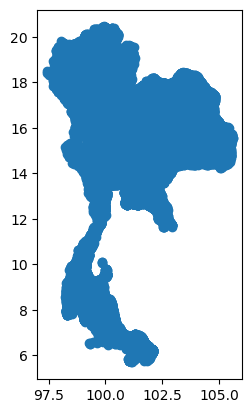

In [55]:
gpd.GeoDataFrame(gdfx3_clean).plot()